In [1]:
import logging

log = logging.getLogger(__name__)
import argparse
import datetime
import sys
import pymc3 as pm
import theano.tensor as tt
import pickle
import pandas as pd
import numpy as np
import scipy.special
from multiprocessing import cpu_count
import matplotlib.pyplot as plt


sys.path.append("../covid19_inference")
sys.path.append("..")

import data
from causal_covid.data import load_cases, load_infectiability
from causal_covid.utils import get_cps, day_to_week_matrix
from causal_covid.model import (
    create_model_single_dimension,
    create_model_multidmensional,
    create_model_single_dimension_infectiability,
)

from covid19_inference import Cov19Model
from covid19_inference.model import (
    lambda_t_with_sigmoids,
    kernelized_spread_with_interaction,
    kernelized_spread,
    week_modulation,
    student_t_likelihood,
    delay_cases,
    uncorrelated_prior_E,
)

In [2]:
begin = datetime.datetime(2021, 8, 1)
end = datetime.datetime(2021, 10, 1)
file = "../data/2022-02-09_16-39-19_young_to_old_cap/scenario_export/observed_infection_data.csv"
cases_df = load_cases(file, begin, end, num_age_groups=1)

vaccination_file = "./../data/2022-02-09_16-39-19_young_to_old_cap/scenario_export/observed_vaccination_data.csv"
waning_file = "./../data/2022-02-09_16-39-19_young_to_old_cap/scenario_export/vaccine_efficacy_waning_data.csv"
population_file = "./../data/2022-02-09_16-39-19_young_to_old_cap/scenario_export/population_data.csv"
observed_U2_file = "./../data/2022-02-02_14-19-24_observed_vac_policy/vaccination_policy/U_2.npy"
observed_U3_file = "./../data/2022-02-02_14-19-24_observed_vac_policy/vaccination_policy/u_3.npy"

diff_data_sim = 14+7 # plus 7 days because data begin 6 days earlier as the reported index at the end of the week
begin_infectiability = begin - datetime.timedelta(days=diff_data_sim)

infectiability_df = load_infectiability(vaccination_file, population_file, observed_U2_file, observed_U3_file, waning_file, begin_infectiability, end, num_age_groups=1)

model = create_model_single_dimension_infectiability(cases_df, infectiability_df, N_population=10 ** 7)
# model2 = create_model_multidmensional(cases_df, [10**8, 10**8, 10**8])
trace = pm.sample(model=model, return_inferencedata=True)

INFO     [causal_covid.utils] pr_sigma_date_transient was set to default value 1.5
INFO     [causal_covid.utils] pr_sigma_lambda was set to default value 0.2
INFO     [causal_covid.utils] relative_to_previous was set to default value True
INFO     [causal_covid.utils] pr_factor_to_previous was set to default value 1.0
INFO     [causal_covid.utils] pr_median_lambda was set to default value 0.125
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_E
INFO     [covid19_inference.model.compartmental_models] kernelized spread
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, median_incubation, I_begin_ratio_log_L2_raw, sigma_I_begin_ratio_log_L1

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5208 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5208 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does n

ValueError: cannot reshape array of size 0 into shape (91,0,newaxis)

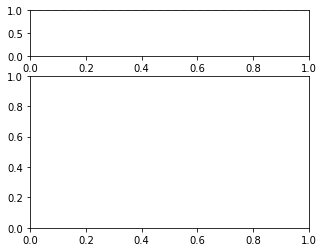

In [3]:
## Plotting

import matplotlib.dates as mdates


def format_date_axis(ax):
    """
    Formats axis with dates
    """
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4, byweekday=mdates.SU))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1, byweekday=mdates.SU))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))


f, axes = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw=dict(height_ratios=(0.3, 1)))
t = [
    cases_df.index[-1] - datetime.timedelta(days=i)
    for i in range(len(cases_df) * 7, -1, -1)
]
ax = axes[0]
ax.axhline(1, ls="--", color="gray", alpha=0.5)
ax.fill_between(
    t,
    *np.percentile(trace.posterior.base_R_t[..., 14:-13], axis=(0, 1), q=(12.5, 87.5)),
    alpha=0.3,
    color="tab:blue",
    label="model (75% & 95% CI)"
)
ax.fill_between(
    t,
    *np.percentile(trace.posterior.base_R_t[..., 14:-13], axis=(0, 1), q=(2.5, 97.5)),
    alpha=0.3,
    color="tab:blue"
)
ax.set_xlim(min(t), max(t))
ax.set_ylabel("Effective $R_t$")
format_date_axis(ax)

ax = axes[1]

ax.fill_between(
    cases_df.index,
    *np.percentile(trace.posterior.weekly_cases, axis=(0, 1), q=(12.5, 87.5)),
    alpha=0.3,
    color="tab:blue",
    label="model (75% & 95% CI)"
)
plt.fill_between(
    cases_df.index,
    *np.percentile(trace.posterior.weekly_cases, axis=(0, 1), q=(2.5, 97.5)),
    alpha=0.3,
    color="tab:blue"
)
plt.plot(cases_df.index, np.array(cases_df), "d", color="k", label="data")
plt.xlabel("2021")
plt.ylabel("Weekly cases")
ax.set_xlim(min(t), max(t))
ax.set_ylim(0)
format_date_axis(ax)
plt.legend()
plt.tight_layout()